In [1]:
import datetime

import pandas as pd
import spacy
import re
import string
import numpy as np


import seaborn as sns
from matplotlib import cm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

from spacy.tokens import Token
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import gensim
from gensim import corpora, models
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import HdpModel

from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import itertools

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from ipywidgets import interact

import nltk
from nltk.corpus import stopwords
from textblob import TextBlob

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

import enchant
pd.set_option('display.max_rows', 500)

/Users/balaji/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/Users/balaji/anaconda3/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


In [2]:
dict_check = enchant.Dict("en_US")

#### Importing the file ####
Path="src/"
Filename='projects_Preprocessed.csv'
df=pd.read_csv(Path+Filename)

Cat_File="category_hier.csv"
Cat_data=pd.read_csv(Path+Cat_File)

varcluster_file="variable_clusters.csv"
varcluster=pd.read_csv(Path+varcluster_file)

manualtag=pd.read_csv(Path+'SamplesManualTagger.csv')
varcluster_info=pd.read_csv(Path+'variable_clusters_info_v2.csv')

df=df[df['Translates']!="The goal of the Heisenberg Program is to enable outstanding scientists who fulfill all the requirements for a long-term professorship to prepare for a scientific leadership role and to work on further research topics during this time. In pursuing this goal, it is not always necessary to choose and implement project-based procedures. For this reason, in the submission of applications and later in the preparation of final reports - unlike other support instruments - no 'summary' of project descriptions and project results is required. Thus, such information is not provided in GEPRIS."]

## Filtering the null abstracts & short description
df=df[(pd.isnull(df.PreProcessedDescription)==False) & (df.PreProcessedDescription.str.strip()!='abstract available')& (df.PreProcessedDescription.str.len()>100) & (pd.isnull(df["SubjectArea"])==False)]

# Striping the category column
Cat_data.Category=Cat_data.Category.str.strip()

## Merging the high level category information

df=df.merge(Cat_data[["File_Categories","Category"]], how="left", left_on="SubjectArea", right_on="File_Categories")

dbdf=pd.read_csv(Path+'Report_WEPCADBScanFindingsKMeansV3.csv')

In [3]:
## Only keeping noun and adjective

df.PreProcessedDescription=df.PreProcessedDescription.apply(lambda x : ' '.join([i for i,pos in TextBlob(x).tags if pos in ['NN','JJ']]))

In [4]:
manualstopwords=['research','group','subject','process','development','analysis','model','different','new','process','study','change','system','approach', 'phase', 'high', 'develop', 'allow','investigation','property','interaction','university', 'device', 'institute', 'researcher', 'science', 'fund', 'facility', 'coordination', 'cooperation']

In [5]:
varcluster_info.cluster_id=varcluster_info.cluster_id.astype('int32')
varclusterall=varcluster.merge(varcluster_info, how='left',left_on='Cluster', right_on='cluster_id')
newstopwords=varclusterall[(varclusterall.cluster_name=='General') | (varclusterall.cluster_name=='Text & Publish') ].Variable.tolist()+manualstopwords
#.sort_values(by='RS_Ratio')

In [6]:
df.PreProcessedDescription=[' '.join([words for words in abstract.split() if(not words in newstopwords)]) for abstract in df.PreProcessedDescription ]

### Preprocessing 

In [7]:
# TF IDF Conversion

vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
review_vectors = vectorizer.fit_transform(df["PreProcessedDescription"])
features_df = pd.DataFrame(review_vectors.toarray(), columns = vectorizer.get_feature_names())

features_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)
merged_data=pd.concat([df,features_df], axis=1,ignore_index=False)

#wordslist=merged_data.columns.tolist()[len(df.columns)+6:]

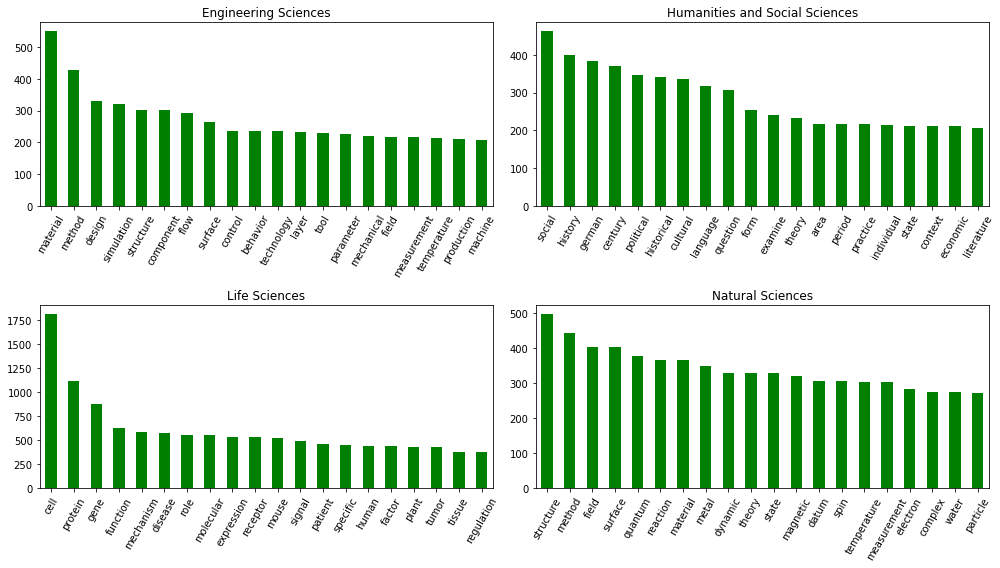

In [8]:
wordslist=merged_data.columns.tolist()[len(df.columns)+2:]

plt.subplots(figsize=(14,8)) 
i=1
categories=[]
category_words=[]

for cat,bucket in merged_data.groupby('Category'):
    
    plt.subplot(2,2,i)
    bucket[wordslist].sum().sort_values(ascending=False).head(20).plot(kind='bar',color='green')
    plt.title(cat)
    plt.xticks(rotation=60)
    i=i+1
    plt.tight_layout()
    categories.append(cat)
    category_words.append( ' '.join(bucket[wordslist].sum().sort_values(ascending=False).head(50).index.tolist()))

CategoryImpoWords=pd.DataFrame({'Category':categories,'Words':category_words})

In [9]:
CategoryImpoWords.Words.tolist()

['material method design simulation structure component flow surface control behavior technology layer tool parameter mechanical field measurement temperature production machine influence datum particle test order problem use stress possible numerical experimental condition increase load alloy optimization technique dynamic network quality large area form sensor element concept measure performance algorithm low',
 'social history german century political historical cultural language question form examine theory area period practice individual state context economic literature hand law focus policy early european concept literary knowledge germany central perspective modern basis religious society culture medium important relationship international discourse national public life collection order manuscript market datum',
 'cell protein gene function mechanism disease role molecular expression receptor mouse signal patient specific human factor plant tumor tissue regulation response acti

In [10]:
CategoryImpoWords.loc[CategoryImpoWords.Category=='Engineering Sciences', 'Words']='engineer method simulation component flow surface behavior technology tool parameter mechanical field measurement temperature production machine particle numerical optimization technique sensor element measure performance algorithm'
CategoryImpoWords.loc[CategoryImpoWords.Category=='Humanities and Social Sciences', 'Words']='humanity social history country century political cultural language economic literature law early policy european literary knowledge religious society culture national manuscript market'
CategoryImpoWords.loc[CategoryImpoWords.Category=='Life Sciences', 'Words']='biology life cell protein gene disease molecular receptor mouse signal patient human factor plant tumor tissue membrane immune genetic cellular animal specie dna vivo clinical infection brain therapy inflammatory therapeutic'
CategoryImpoWords.loc[CategoryImpoWords.Category=='Natural Sciences', 'Words']='natural field surface quantum metal theory magnetic spin temperature measurement electron water complex particle energy compound molecule chemical electronic synthesis transition molecular optical climate spectroscopy resolution organic gas polymer sediment mathematic'

In [11]:
## Repeated words in category

word=[]
for x in [cc.split() for cc in CategoryImpoWords.Words]:
    word.extend(x)
pd.Series(word).value_counts().sort_values(ascending=False).head(16)#.index.tolist()

measurement    2
molecular      2
particle       2
temperature    2
field          2
surface        2
mouse          1
infection      1
behavior       1
technique      1
history        1
climate        1
literary       1
cultural       1
theory         1
algorithm      1
dtype: int64

In [12]:
CategoryImpoWords.loc[CategoryImpoWords.Category=='Humanities and Social Sciences', 'Words']='humanity social history country century political cultural language economic law early policy european literary knowledge religious society culture national manuscript market'
CategoryImpoWords.loc[CategoryImpoWords.Category=='Natural Sciences', 'Words']='mathematic natural field surface quantum metal theory magnetic spin temperature measurement electron water complex particle energy compound molecule chemical electronic synthesis transition molecular optical climate spectroscopy resolution organic gas polymer sediment '

doc='direct method spatial statistic natural technology computer feedback orientate theory mathematic partner main emphasis stochastic young specialist progress thesis order individual knowledge interdisciplinary contact seminar lecture colloquium special'

for ip in CategoryImpoWords.iterrows():
    print(ip[1].Category, similarity_scores(doc, ip[1]['Words'],50))


NameError: name 'similarity_scores' is not defined

#### 1.1 Word Embedding

In [ ]:
## Word Embeddings Functions

## Generate the tagged documents (tagging based on the category column)
def create_tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

## Generate the tagged documents (each record in single tag )
def create_tagged_document_based_on_tags(list_of_list_of_words, tags):
    for i in range(len(list_of_list_of_words)):
        yield gensim.models.doc2vec.TaggedDocument(list_of_list_of_words[i], [tags[i]])

def make_bigram(inputlist):
    bigram = Phrases(inputlist, min_count=3, threshold=1,delimiter=b' ')
    bigram_phraser = Phraser(bigram)
    new_list=[]
    for sent in inputlist:
        new_list.append(bigram_phraser[sent])
    return new_list        
        
## Generate output using the word embedding model prediction - takes long time to regenerate
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs#.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
## creating a tagged document
#DescDict=make_bigram([[x for x in str(i).split()] for i in df.PreProcessedDescription])
DescDict=[[x for x in str(i).split()] for i in df.PreProcessedDescription]


#tagged_value_tags = list(create_tagged_document_based_on_tags(DescDict, df.Category.tolist()))
tagged_value = list(create_tagged_document(DescDict))

In [ ]:
print(str(datetime.datetime.now()),'Started')

# Init the Doc2Vec model
model = gensim.models.Word2Vec(DescDict,size=50, min_count=1, alpha = 0.02, sg=0, seed=42, workers=4)

#### Hyper parameter ####
print(str(datetime.datetime.now()),'Completed')

In [ ]:
## Validating the model response for random words 

modelchecked=model
target_word='mathematic'
print('target_word: %r model: %s similar words:' % (target_word, modelchecked))
for i, (word, sim) in enumerate(modelchecked.wv.most_similar(target_word, topn=10), 1):
    print('    %d. %.2f %r' % (i, sim, word))

In [ ]:
modelchecked.similarity('country','german')

In [ ]:
###############################
#### similarity functions #####
###############################

def map_word_frequency(document):
    return Counter(itertools.chain(*document))
    
def get_sif_feature_vectors(sentence1, sentence2, word_emb_model=modelchecked):
    sentence1 = [token for token in sentence1.split() if token in word_emb_model.wv.vocab]
    sentence2 = [token for token in sentence2.split() if token in word_emb_model.wv.vocab]
    word_counts = map_word_frequency((sentence1 + sentence2))
    embedding_size = 50 # size of vectore in word embeddings
    a = 0.0001
    sentence_set=[]
    for sentence in [sentence1, sentence2]:
        vs = np.zeros(embedding_size)
        sentence_length = len(sentence)
        for word in sentence:
            a_value = a / (a + word_counts[word]) # smooth inverse frequency, SIF
            vs = np.add(vs, np.multiply(a_value, word_emb_model.wv[word])) # vs += sif * word_vector
        vs = np.divide(vs, sentence_length) # weighted average
        sentence_set.append(vs)
    return sentence_set

def get_cosine_similarity(feature_vec_1, feature_vec_2):    
    return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]

def similarity_scores(sentence1, sentence2, n=50):
    sentence1=sentence1.replace(',','')
    sentence2=sentence2.replace(',','')
    features=get_sif_feature_vectors(sentence1, sentence2)
    return get_cosine_similarity(features[0][:n],features[1][:n])

### Direct Comparision

In [ ]:
Sims={'Natural Sciences':[], 'Humanities and Social Sciences':[],'Engineering Sciences':[], 'Life Sciences':[]}
size=len(df.PreProcessedDescription)
with tqdm(total=size) as bar:
    for i in range(len(df.PreProcessedDescription)):
        topicWord=df.loc[i].PreProcessedDescription
        for s in Sims.keys():
            CatWords=CategoryImpoWords[CategoryImpoWords.Category==s].Words.values[0]
            Sims[s].append(similarity_scores(topicWord, CatWords,50))
        bar.update(1)

In [ ]:
df_Sim=pd.DataFrame(Sims)

def top_matchings(input):
    
    input=input.sort_values(ascending=False)
    
    PrimaryMatching=input.head(1).tail(1).index.values[0]
    PrimaryMatchingSim=input.head(1).tail(1).values[0]
    
    SecMatching=input.head(2).tail(1).index.values[0]
    SecMatchingSim=input.head(2).tail(1).values[0]
    
    ThrdMatching=input.head(3).tail(1).index.values[0]
    ThrdMatchingSim=input.head(3).tail(1).values[0]
    
    #if(PrimaryMatchingSim<.70):
    #    PrimaryMatchingSim=0
    #    PrimaryMatching=''
    #if(SecMatchingSim<.70):
    #    SecMatchingSim=0
    #    SecMatching=''
    
    return PrimaryMatching,PrimaryMatchingSim,SecMatching,SecMatchingSim,ThrdMatching,ThrdMatchingSim

df_Sim.head().apply(top_matchings,axis=1, result_type="expand")
    
df_Sim1=df_Sim.apply(top_matchings,axis=1, result_type="expand")
df_Sim1.columns=['PrimaryMatching','PrimaryMatchingSim','SecMatching','SecMatchingSim','ThrdMatching','ThrdMatchingSim']


In [374]:
Merged_df=pd.concat([df,df_Sim1], axis=1)
thersold_1=.6
thersold_2=.6
thersold_3=.6


Merged_df.loc[(Merged_df.PrimaryMatchingSim<thersold_1),'PrimaryMatching']=''
Merged_df.loc[(Merged_df.PrimaryMatchingSim<thersold_1) | (Merged_df.SecMatchingSim<thersold_2),'SecMatching']=''
Merged_df.loc[(Merged_df.PrimaryMatchingSim<thersold_1) | (Merged_df.SecMatchingSim<thersold_2) | (Merged_df.ThrdMatchingSim<thersold_3),'ThrdMatching']=''

Merged_df['ID_Categories']=Merged_df.apply(lambda x: ','.join(sorted([x['PrimaryMatching'],x['SecMatching'],x['ThrdMatching']]) ).strip(','), axis=1)

In [375]:
Merged_df['Interdiscipilinary']=True
Merged_df.loc[Merged_df.SecMatching=='','Interdiscipilinary']=False

In [376]:
Merged_df.Interdiscipilinary.value_counts()

False    30718
True     20315
Name: Interdiscipilinary, dtype: int64

In [419]:
#'Category',,'ThrdMatching'
#Merged_df.groupby(['PrimaryMatching','SecMatching']).count()[['SubUrl']]

#Merged_df.groupby(['Category','PrimaryMatching']).count()[['SubUrl']]
#Merged_df[Merged_df.Category=='Life Sciences'].groupby(['PrimaryMatching','SecMatching']).count()[['SubUrl']]
Merged_df[Merged_df.Interdiscipilinary].groupby('ID_Categories').count()[['SubUrl']].sort_values('SubUrl', ascending=False)

,SubUrl
ID_Categories,
"Engineering Sciences,Natural Sciences",18691
"Engineering Sciences,Humanities and Social Sciences",750
"Engineering Sciences,Life Sciences",419
"Engineering Sciences,Life Sciences,Natural Sciences",260
"Life Sciences,Natural Sciences",178
"Engineering Sciences,Humanities and Social Sciences,Natural Sciences",15
"Humanities and Social Sciences,Natural Sciences",2


In [413]:
#Merged_df.loc[(Merged_df.Category=='Engineering Sciences') & (Merged_df.PrimaryMatching=='Life Sciences'),'Translates'].head(10).tolist()
#Merged_df.loc[(Merged_df.PrimaryMatching=='Natural Sciences') & (Merged_df.SecMatching=='Engineering Sciences'),'Translates'].head(10).tolist()

Merged_df.loc[(Merged_df.ID_Categories=='Engineering Sciences,Natural Sciences') ,'Translates'].head(10).tolist()

['The goal of this program consists in the mathematical formulation of miniaturized fluidic systems, in the design and realization on the basic of printed board technology and additive technique. As fluidic actuators are realized thermal drived pumps, thermal controlled valves, filter a.s.o. The integration of piezoelectrical actuators is included. As sensors are integrated structures to measure the electrochemical conductivity or the pH value and biochemical sensors, optical sensors a.s.o. The electronically signal processing included the hardware of artificial neural network. An another point of the research program is the realization of sensor-actuator systems for the measuring of circuits in electrochemical solutions. By short-term heating of measuring electrods are initiated chemical reactions and it will be possible to analyse special chemical substances (Hot Layer Technology). A special goal concerned the analyse of nuclein acid, of DNA fragments and biologically active substanc

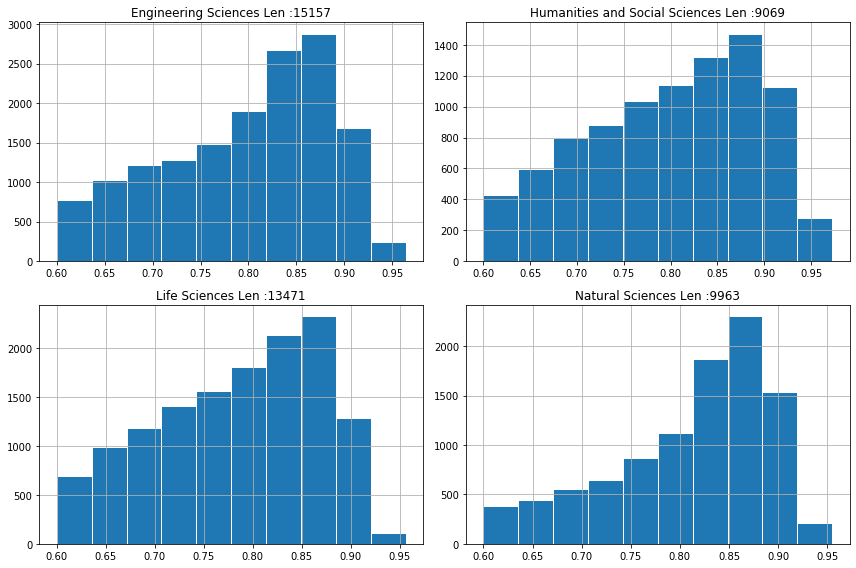

In [420]:
i=1
plt.figure(figsize=(12, 8))
for cc,w in Merged_df[Merged_df.PrimaryMatching!=''].groupby(['PrimaryMatching']):
    plt.subplot(2,2,i)
    w['PrimaryMatchingSim'].hist( edgecolor='white', linewidth=1)    
    plt.title(str(cc)+' Len :'+str(len(w)))
    i=i+1
plt.tight_layout()

In [421]:
Merged_df.to_csv(Path+'IDBasedonSimliarity2.csv', index=False)

In [710]:
Merged_df.loc[Merged_df.PrimaryMatching=='','PrimaryMatchingSim']=np.NaN
Merged_df.loc[Merged_df.SecMatching=='','SecMatchingSim']=np.NaN
Merged_df.loc[Merged_df.ThrdMatching=='','ThrdMatchingSim']=np.NaN

In [712]:
for c1 in Merged_df.Category.unique():
    CategoryImpoWords[c1]=0
    for c2 in Merged_df.Category.unique():
        countvalues=len(Merged_df.loc[(Merged_df.ID_Categories.str.contains(c1,case=False)) & (Merged_df.ID_Categories.str.contains(c2,case=False))])
        if((c1==c2) | (countvalues==0) ):
            CategoryImpoWords.loc[CategoryImpoWords.Category==c2,c1]=0
        else:
            CategoryImpoWords.loc[CategoryImpoWords.Category==c2,c1]=np.log(countvalues)
        #print(c1,c2,countvalues)
#        pass

CategoryImpoWords[Merged_df.Category.unique()]=CategoryImpoWords[Merged_df.Category.unique()].max().max()+0.01-CategoryImpoWords[Merged_df.Category.unique()]

for c1 in Merged_df.Category.unique():
    for c2 in Merged_df.Category.unique():
        if((c1==c2)):
            CategoryImpoWords.loc[CategoryImpoWords.Category==c2,c1]=0
            


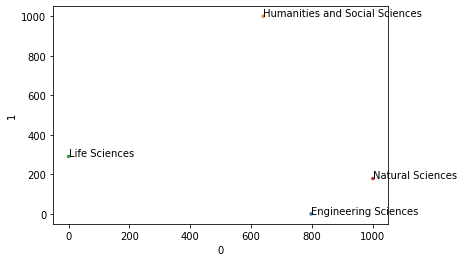

In [713]:
## Generating coordinates from distance


coords = TSNE(n_components=2,perplexity=1, random_state=12).fit_transform(CategoryImpoWords[Merged_df.Category.unique()])
#coords = PCA(n_components=2).fit_transform(CategoryImpoWords[[ 'Engineering Sciences','Humanities and Social Sciences', 'Life Sciences', 'Natural Sciences']])

coords=MinMaxScaler([0,1000]).fit_transform(coords)
coords=pd.DataFrame(coords, index=CategoryImpoWords.Category).reset_index()
p1=sns.scatterplot(
    x=0, y=1,
    hue="Category",
 #   palette=sns.color_palette("hls", 4),
    data=coords,
   # legend="full",
    alpha=1,
    size = 8,
    legend=False
)

for line in range(0,coords.shape[0]):
     p1.text(coords[0][line]+0.01, coords[1][line], CategoryImpoWords.Category[line], horizontalalignment='left',  size='medium', color='black')

In [714]:
cat_dict=pd.DataFrame(Merged_df[Merged_df.ID_Categories!='']['ID_Categories'].value_counts())
cats=[]

#temp=[ cats.extend([c+'_1',c+'_2',c+'_3']) for c in Merged_df.Category.unique()]
#for t in cats:
#    cat_dict[t]=10#.00
    
#for cx in cat_dict.iterrows():
#    i=1
#    counts=np.log(cx[1]['ID_Categories'])/len(cx[0].split(','))
#    for cc in cx[0].split(','):
#        cat_dict.loc[cx[0]][cc+'_'+str(i)]=10-counts
#        #print(cc+'_'+str(i) , '-',cx[1]['ID_Categories']/len(cx[0].split(',')), cat_dict.loc[cx[0]][cc+'_'+str(i)])
#        i=i+1

cats=Merged_df.Category.unique()

for c in Merged_df.Category.unique():
    cat_dict[c]=10#.00

for cx in cat_dict.iterrows():
    catlist=cx[0].split(',')
    cxmeans=CategoryImpoWords[CategoryImpoWords.Category.isin(catlist)].mean()
    for c in Merged_df.Category.unique():
        #print(cx[0],':',c)
        cat_dict.loc[cx[0],c]=cxmeans[c]
    

In [715]:
cat_dict.reset_index().sort_values(by='index')

,index,ID_Categories,Natural Sciences,Humanities and Social Sciences,Engineering Sciences,Life Sciences
3,Engineering Sciences,4286,0.010000,3.220527,0.000000,3.339782
5,"Engineering Sciences,Humanities and Social Sci...",750,3.518595,1.610264,1.610264,6.600093
9,"Engineering Sciences,Humanities and Social Sci...",15,2.345730,3.415906,1.076842,5.659457
6,"Engineering Sciences,Life Sciences",419,1.894092,6.540465,1.669891,1.669891
7,"Engineering Sciences,Life Sciences,Natural Sci...",260,1.262728,6.702707,1.116594,2.372655
0,"Engineering Sciences,Natural Sciences",18691,0.005000,5.123859,0.005000,3.558983
2,Humanities and Social Sciences,8594,7.027190,0.000000,3.220527,9.860403
10,"Humanities and Social Sciences,Natural Sciences",2,3.513595,3.513595,1.615264,6.819294
1,Life Sciences,13017,3.778184,9.860403,3.339782,0.000000
8,"Life Sciences,Natural Sciences",178,1.889092,8.443797,1.674891,1.889092


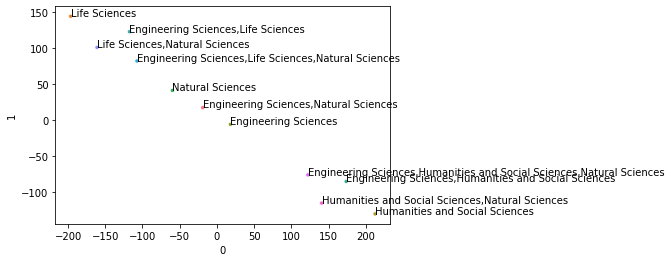

In [752]:
#coords = TSNE(n_components=2,perplexity=5, random_state=12).fit_transform(cat_dict[cats])
coords = TSNE(n_components=2,perplexity=3.3, random_state=42, n_iter=850).fit_transform(cat_dict[cats])

coords=pd.DataFrame(coords, index=cat_dict.index).reset_index()
p1=sns.scatterplot(
    x=0, y=1,
    hue="index",
 #   palette=sns.color_palette("hls", 4),
    data=coords,
   # legend="full",
    alpha=1,
    size = 8,
    legend=False
)

for line in range(0,coords.shape[0]):
     p1.text(coords[0][line]+0.01, coords[1][line], cat_dict.index[line], horizontalalignment='left',  size='medium', color='black')

In [770]:
coords['size']=list(cat_dict['ID_Categories'])
#coords.to_csv(Path+'IDSimliarityCats.csv', index=False)